### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ same-colored burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

Note: You will see below that my MCMC method using emcee took 30 mins to run with the burst model. I think even with 100K samples of the posterior, I needed more to get a nicer corner plot. I definitely did not do all I could to vectorize operations, but convergence seems to be happening nonetheless. I think extra samples would be ideal though. I tried running 1 million steps using the below methods, but it went on for 3 hours and I had to terminate it so I could get my submission in on time. I stuck with 100K samples.

### Solution

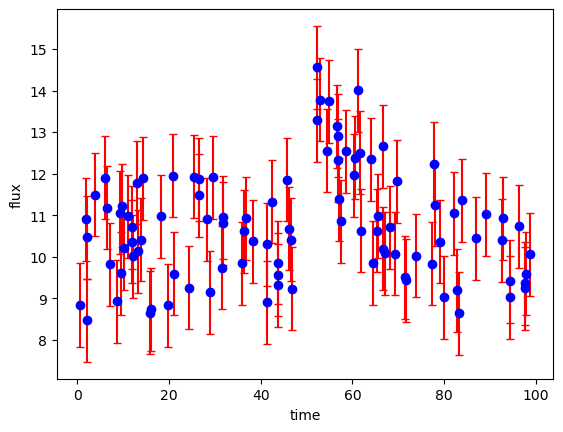

In [1]:
# PART 1

from matplotlib import pyplot as plt
import numpy as np

filename = "/Users/harvir_d/NEW_repos/astr_8070_s25/coursework/homeworks/hw_data/hw5_data_1.npy" # file path
data = np.load(filename) # easy to load multivariate data if from a numpy file

time = data[:,0] # extracting column at a time
flux = data[:,1]
uncertainties = data[:,2]

plt.errorbar(time,flux,yerr=uncertainties,color='blue',ecolor='red',fmt='o',capsize=3)
plt.xlabel('time')
plt.ylabel('flux')
plt.show()


In [2]:
# PART 2

from scipy.stats import norm 

def burst(theta, x):

    return np.where(x < theta[2], # np.where for piece wise behavior
                theta[0], 
                theta[0] + theta[1] * np.exp((-theta[3]) * (x - theta[2]))) # avoiding the use of 'if' conditional in return statement, I thought this would help with run time but it seems not enough


# compute the data log-likelihood given a model
def logL(theta, data, model=burst):
    """Gaussian log-likelihood of the model at theta"""
    x = data[:,0]
    y = data[:,1] 
    sigma_y = data[:,2]
    y_fit = model(theta, x) # passing into burst model
    
    return sum(norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

In [ ]:
# PART 3

import emcee

def background_prior(x):
    return 1.0 / 50 if 0 <= x <= 50 else 0 # making sure to cutoff prior to zero outside range, correcting silly mistakes from homework 4 where I did not do any cut offs for the priors

def amplitude_prior(x):
    return 1.0 / 50 if 0 <= x <= 50 else 0

def epoch_prior(x):
    return 1.0 / 100 if 0 <= x <= 100 else 0

def rapid_prior(x):
    if x <= 0:  # Prevent log of non-positive numbers
        return 0
    log_x = np.log(x)
    return 1.0 / (np.exp(5) - np.exp(-5)) if -5 <= log_x <= 5 else 0 # the question gives the range in ln(alpha)

def logPosterior(theta, data):
    # Compute log priors with proper checks
    log_prior_background = np.log(background_prior(theta[0])) if background_prior(theta[0]) > 0 else -np.inf # maybe this is where the sampler takes awhile, because of these conditionals? Not sure
    log_prior_amplitude = np.log(amplitude_prior(theta[1])) if amplitude_prior(theta[1]) > 0 else -np.inf
    log_prior_epoch = np.log(epoch_prior(theta[2])) if epoch_prior(theta[2]) > 0 else -np.inf
    
    if rapid_prior(theta[3]) > 0 and theta[3] > 0:
        log_prior_rapid = np.log(rapid_prior(theta[3])) - np.log(theta[3]) # since the original range is defined for ln(alpha)
    else:
        log_prior_rapid = -np.inf  # Reject samples outside valid range

    # If any prior is invalid, reject sample, another way to do error handling, I can see why this might not always be good practice though because we might be forcefully removing the possibility of errors in our logic
    if np.isinf(log_prior_background) or np.isinf(log_prior_amplitude) or np.isinf(log_prior_epoch) or np.isinf(log_prior_rapid):
        return -np.inf
    
    return logL(theta, data) + log_prior_background + log_prior_amplitude + log_prior_epoch + log_prior_rapid # summing because log Posterior



ndim = 4  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers
nsteps = 100000  # number of MCMC steps to take for each walker


starting_positions = np.exp(np.random.uniform(0,1, (nwalkers, ndim))) # initial values for parameters 

print("Starting positions:\n", starting_positions)
print("Condition number:", np.linalg.cond(starting_positions)) # condition number ought to be < 15 for a stable mcmc sampling procedure using emcee

corr_matrix = np.corrcoef(starting_positions.T)
print("Correlation matrix:\n", corr_matrix) # correlation matrix is expected to have diagonals of 1s (parameters perfectly correlate with themselves), and ideally low absolute values compared to one on the off-diagonals (do not want strongly correlated parameters as initial states)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=[data]) 

sampler.run_mcmc(starting_positions, nsteps) # running sampler
print(f"Total MCMC steps completed: {sampler.iteration}") # ensuring 100K steps


Starting positions:
 [[1.06301969 1.26870648 1.98704406 2.27563918]
 [1.7080684  2.1386972  1.60899207 2.40186093]
 [1.09415952 2.24731947 2.15675122 1.5283274 ]
 [1.71126593 1.77223047 1.25225984 1.31789657]
 [2.20955715 2.46512726 2.70317484 2.45460083]
 [1.11957313 1.76135272 2.54554314 2.06811051]
 [2.33715348 1.75208745 2.21223477 1.44502794]
 [2.14441045 2.59764957 1.12664983 1.50822883]]
Condition number: 12.20160171378851
Correlation matrix:
 [[ 1.          0.48790875 -0.15009086 -0.17169383]
 [ 0.48790875  1.         -0.12018509 -0.04658728]
 [-0.15009086 -0.12018509  1.          0.46962604]
 [-0.17169383 -0.04658728  0.46962604  1.        ]]


/var/folders/5y/r0thn5qs437_z1rk3srjhx3r0000gn/T/ipykernel_91061/1856353921.py:9: RuntimeWarning: overflow encountered in exp
  theta[0] + theta[1] * np.exp((-theta[3]) * (x - theta[2])))
/var/folders/5y/r0thn5qs437_z1rk3srjhx3r0000gn/T/ipykernel_91061/1856353921.py:9: RuntimeWarning: overflow encountered in multiply
  theta[0] + theta[1] * np.exp((-theta[3]) * (x - theta[2])))


Total MCMC steps completed: 100000


In [ ]:
# PART 4

tau = sampler.get_autocorr_time(tol=0)  # Get the autocorrelation time for each parameter (number of steps sufficient for chain to "forget" initial state)
print(f"Autocorrelation times: {tau}")
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction)) # want ideal acceptance rate not too high (exploring small region of 4D parameter space) and not too low (making big jumps)

Autocorrelation times: [ 142.58864185 2842.96756809 1234.5639904  2119.87224235]
Mean acceptance fraction: 0.50017875


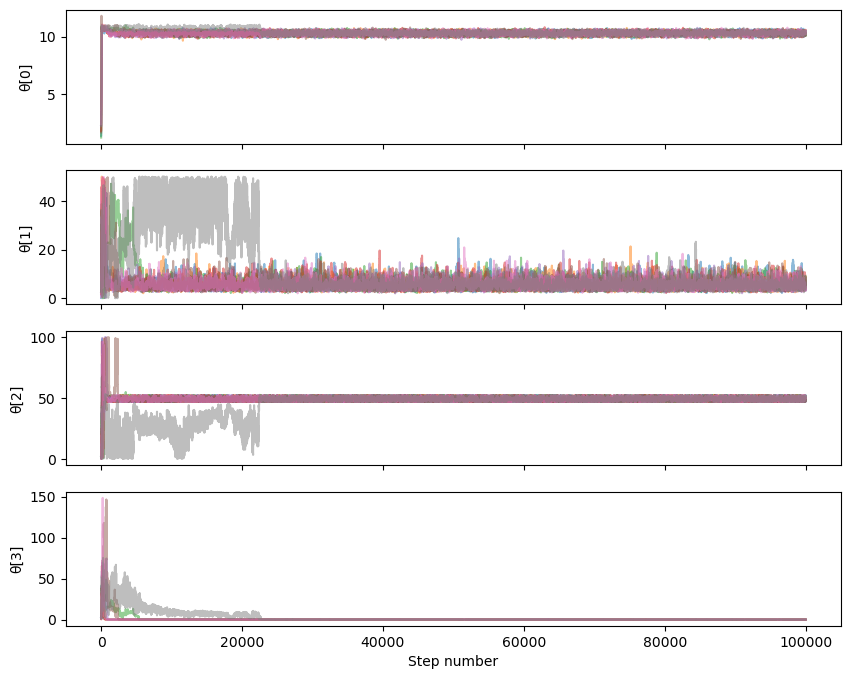

In [ ]:
# PART 4 CONTINUED

import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)  # Flatten the chain to see if it is as expected
samples = samples.reshape(-1, nwalkers, ndim) # reshape to get back into proper dimensions

fig, axes = plt.subplots(ndim, figsize=(10, ndim * 2), sharex=True)

# Loop through the dimensions and plot each parameter's trace
for i in range(ndim):
    for walker in range(nwalkers):
        axes[i].plot(samples[:, walker, i], alpha=0.5)  # Plot each walker’s trace
    axes[i].set_ylabel(f"θ[{i}]")

axes[-1].set_xlabel("Step number")
plt.show()


Final theta: [10.24761996  4.77930968 51.63068858  0.1235986 ]
Burn-in length: 14214 steps
Remaining samples shape: (686288, 4)


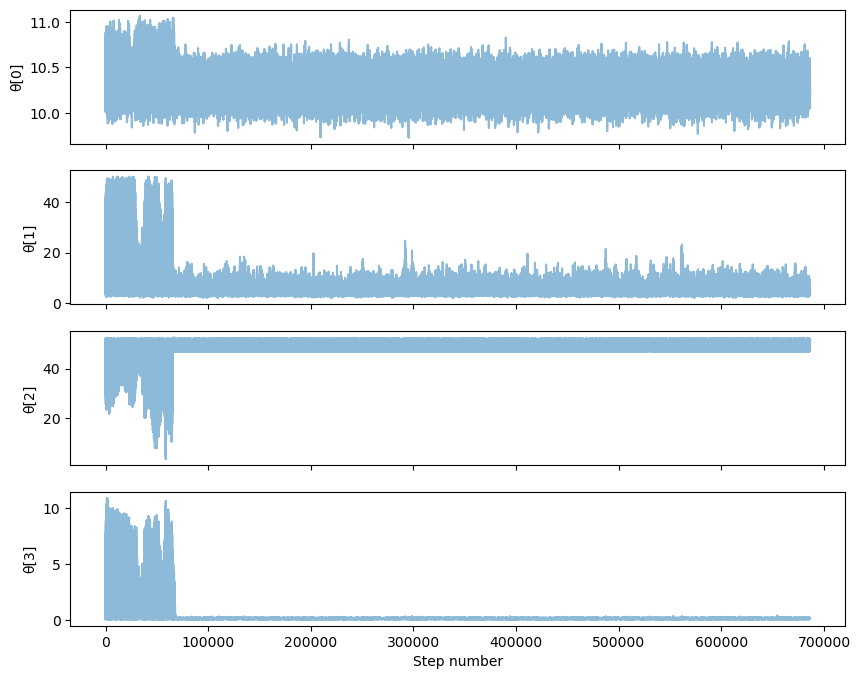

In [8]:
# PART 4 CONTINUED

burn_in = int(5 * np.max(tau))  # I will discard 5 times the autocorrelation number of steps 

samples_burned = sampler.get_chain(discard=burn_in, flat=True)

final_theta = samples_burned[-1]  # Last posterior sample
print("Final theta:", final_theta) # see what we converge to

# Print how many steps were discarded
print(f"Burn-in length: {burn_in} steps")
print(f"Remaining samples shape: {samples_burned.shape}")

fig, axes = plt.subplots(ndim, figsize=(10, ndim * 2), sharex=True) # plot again, this time with burned-in chain

for i in range(ndim):
    axes[i].plot(samples_burned[:, i], alpha=0.5)
    axes[i].set_ylabel(f"θ[{i}]")

axes[-1].set_xlabel("Step number")
plt.show()

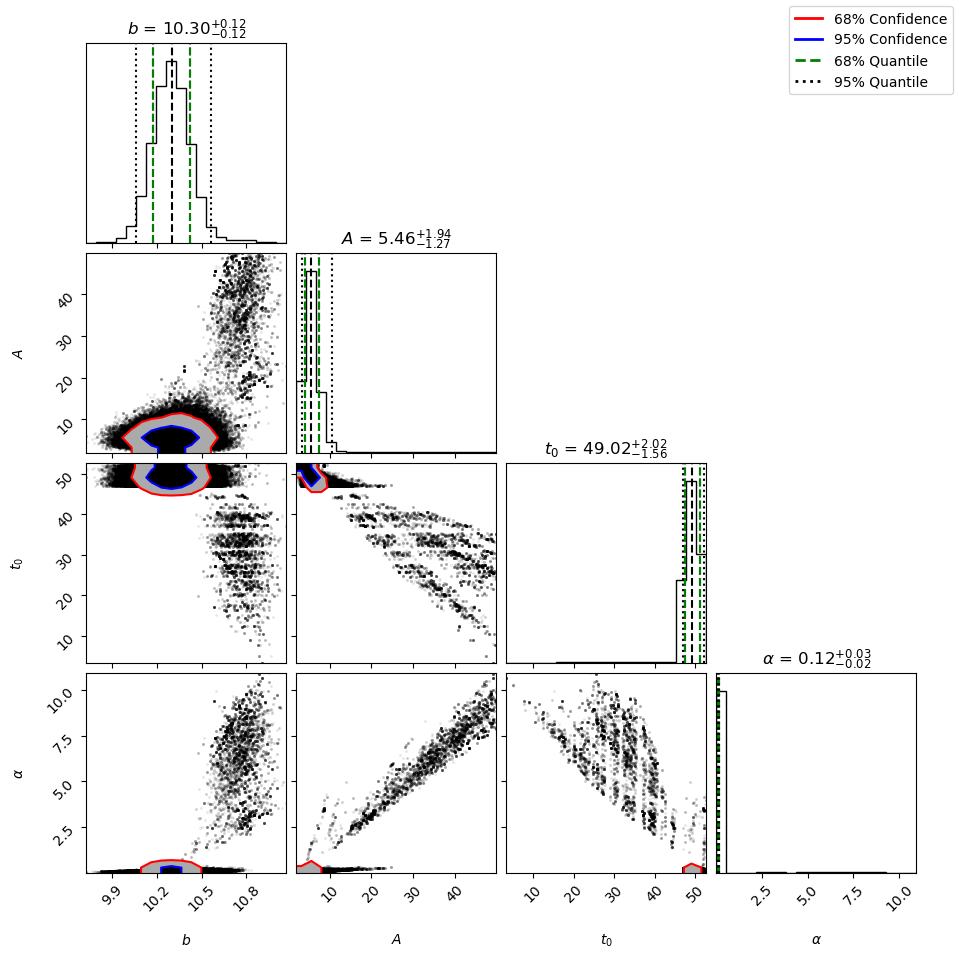

In [ ]:
# PART 5 

import corner


# Define labels for all the plots
labels = [r"$b$", r"$A$", r"$t_0$", r"$\alpha$"]

# Compute percentiles for confidence intervals, including 50th quantile for visual purposes
percentiles = [16, 50, 84]  # 68% interval
percentiles_95 = [2.5, 50, 97.5]  # 95% interval
theta_median = np.median(samples_burned, axis=0)
theta_68 = np.percentile(samples_burned, [16, 84], axis=0)
theta_95 = np.percentile(samples_burned, [2.5, 97.5], axis=0)


fig = corner.corner(
    samples_burned,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    plot_datapoints=True,
    plot_contours=True,
    fill_contours=True,
    levels=[0.68, 0.95],  # confidence intervals
    contour_kwargs={"colors": ["red", "blue"]},  # red for 68%, blue for 95%
)

# Get the axes for adding vertical lines
axes = np.array(fig.axes).reshape((4, 4))  # Adjust for 4D

for i in range(4):  # iterate over the diagonal subplots (marginal distributions)
    ax = axes[i, i]

    # Vertical lines for 68% and 95% intervals
    ax.axvline(theta_68[0, i], color="green", linestyle="--", label="68% Quantile")
    ax.axvline(theta_68[1, i], color="green", linestyle="--")
    
    ax.axvline(theta_95[0, i], color="black", linestyle=":", label="95% Quantile")
    ax.axvline(theta_95[1, i], color="black", linestyle=":")

# Add legend to the plot
handles = [
    plt.Line2D([0], [0], color="red", linewidth=2, label="68% Confidence"),
    plt.Line2D([0], [0], color="blue", linewidth=2, label="95% Confidence"),
    plt.Line2D([0], [0], color="green", linestyle="--", linewidth=2, label="68% Quantile"),
    plt.Line2D([0], [0], color="black", linestyle=":", linewidth=2, label="95% Quantile"),
]

fig.legend(handles=handles, loc="upper right", fontsize=10)

plt.show()


Note: I know these corner plots are not quite right. The histograms make sense to me and look reasonable, but I think the number of samples is limiting interpretability of the other plots.

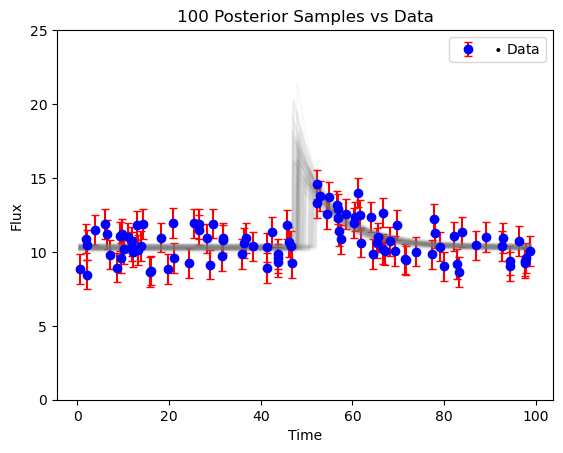

In [21]:
# PART 6

filename = "/Users/harvir_d/NEW_repos/astr_8070_s25/coursework/homeworks/hw_data/hw5_data_1.npy"
data = np.load(filename)

time = data[:, 0]  # Extracting time
flux = data[:, 1]  # Extracting flux
uncertainties = data[:, 2]  # Extracting uncertainties

# Select 100 random posterior samples
num_samples = 100
random_indices = np.random.choice(len(samples_burned), num_samples, replace=False) #sampling without replacement
posterior_samples = samples_burned[random_indices]  # Shape (100, 4)

# Plot original data with error bars
plt.errorbar(time, flux, yerr=uncertainties, color='blue', ecolor='red', fmt='o', capsize=3, label=r"$\bullet$ Data", markersize=6)


x_fine = np.linspace(min(time), max(time), 500) 

for i, theta in enumerate(posterior_samples): # Plot 100 random posterior models with varying transparency, enumerate assigns index that I can use for transparency changes
    alpha_value = 0.05 + 0.005 * (i / num_samples)  # Vary transparency slightly
    plt.plot(x_fine, burst(theta, x_fine), color='gray', alpha=alpha_value)

# Set y-limit
plt.ylim(0, 25)

# Labels and legend
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('100 Posterior Samples vs Data')
plt.legend()
plt.show()




I think this looks reasonable, we can see an approximate shape to the data for the posteriors

In [26]:
# PART 7

# Gaussian model function
def gaussian_model(theta, x):

    b, A, t_0, sigma_W = theta # unpacking parameters this time, although I think this makes no functional difference to run time

    return b + A * np.exp(-((x - t_0) ** 2) / (2 * sigma_W ** 2))

# Log-likelihood function
def log_likelihood2(theta, data):

    time, flux, uncertainties = data[:, 0], data[:, 1], data[:, 2] # unpacking data
    model_flux = gaussian_model(theta, time) 
    
    # Compute log-likelihood assuming Gaussian errors
    return -0.5 * np.sum(((flux - model_flux) / uncertainties) ** 2)


In [30]:

# Priors like for burst model except for sigma 
def background_prior2(x):
    return 1.0 / 50 if 0 <= x <= 50 else 0

def amplitude_prior2(x):
    return 1.0 / 50 if 0 <= x <= 50 else 0

def epoch_prior2(x):
    return 1.0 / 100 if 0 <= x <= 100 else 0

def sigma_W_prior(x):
    log_x = np.log(x)
    return 1.0 / (np.exp(2) - np.exp(-2)) if -2 <= log_x <= 2 else 0 # range given for ln(sigma)

def logPosterior2(theta, data):
    # Compute log priors with proper checks
    log_prior_background2= np.log(background_prior(theta[0])) if background_prior(theta[0]) > 0 else -np.inf
    log_prior_amplitude2 = np.log(amplitude_prior(theta[1])) if amplitude_prior(theta[1]) > 0 else -np.inf
    log_prior_epoch2 = np.log(epoch_prior(theta[2])) if epoch_prior(theta[2]) > 0 else -np.inf
    
 
    if sigma_W_prior(theta[3]) > 0 and theta[3] > 0:
        log_prior_sigma = np.log(sigma_W_prior(theta[3])) - np.log(theta[3])
    else:
        log_prior_sigma = -np.inf  # Reject samples outside valid range

    # If any prior is invalid, reject sample
    if np.isinf(log_prior_background2) or np.isinf(log_prior_amplitude2) or np.isinf(log_prior_epoch2) or np.isinf(log_prior_sigma):
        return -np.inf
    
    return log_likelihood2(theta, data) + log_prior_background2 + log_prior_amplitude2 + log_prior_epoch2 + log_prior_sigma



ndim = 4  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers
nsteps = 100000  # number of MCMC steps to take for each walker


# Generate starting positions within prior ranges
starting_positions2 = np.array([ # this time assigning initial state based on priors
    np.random.uniform(0, 50, nwalkers),  # b in [0,50]
    np.random.uniform(0, 50, nwalkers),  # A in [0,50]
    np.random.uniform(0, 100, nwalkers), # t_0 in [0,100]
    np.exp(np.random.uniform(-2, 2, nwalkers))  # sigma_W following log prior
]).T  # Transpose to (nwalkers, ndim)

corr_matrix2 = np.corrcoef(starting_positions2.T)
print("Correlation matrix:\n", corr_matrix2)

sampler2 = emcee.EnsembleSampler(nwalkers, ndim, logPosterior2, args=[data])

sampler2.run_mcmc(starting_positions2, nsteps)
print(f"Total MCMC steps completed: {sampler.iteration}")


Correlation matrix:
 [[1.         0.1713513  0.71376381 0.36354419]
 [0.1713513  1.         0.48822747 0.47359326]
 [0.71376381 0.48822747 1.         0.32560443]
 [0.36354419 0.47359326 0.32560443 1.        ]]


/var/folders/5y/r0thn5qs437_z1rk3srjhx3r0000gn/T/ipykernel_91061/2510546858.py:12: RuntimeWarning: invalid value encountered in log
  log_x = np.log(x)


Total MCMC steps completed: 100000


In [31]:
tau2 = sampler2.get_autocorr_time(tol=0)  # Get the autocorrelation time for each parameter
print(f"Autocorrelation times: {tau2}")
print("Mean acceptance fraction:", np.mean(sampler2.acceptance_fraction))

Autocorrelation times: [1749.99388881 4051.9872248  1836.55235536 1803.53994474]
Mean acceptance fraction: 0.3281625


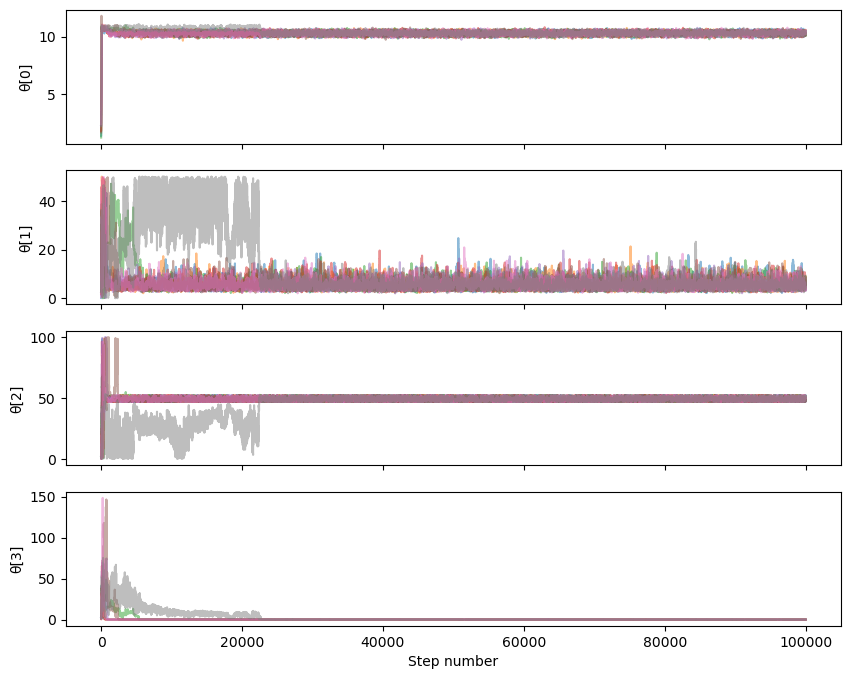

In [32]:
samples2 = sampler2.get_chain(flat=True)  # Flatten the chain to see if it is as expected
samples2 = samples2.reshape(-1, nwalkers, ndim)

fig, axes = plt.subplots(ndim, figsize=(10, ndim * 2), sharex=True)

# Loop through the dimensions and plot each parameter's trace
for i in range(ndim):
    for walker in range(nwalkers):
        axes[i].plot(samples[:, walker, i], alpha=0.5)  # Plot each walker’s trace
    axes[i].set_ylabel(f"θ[{i}]")

axes[-1].set_xlabel("Step number")
plt.show()


Final theta: [10.53266847  2.37001064 55.63415624  5.52765244]
Burn-in length: 20259 steps
Remaining samples shape: (637928, 4)


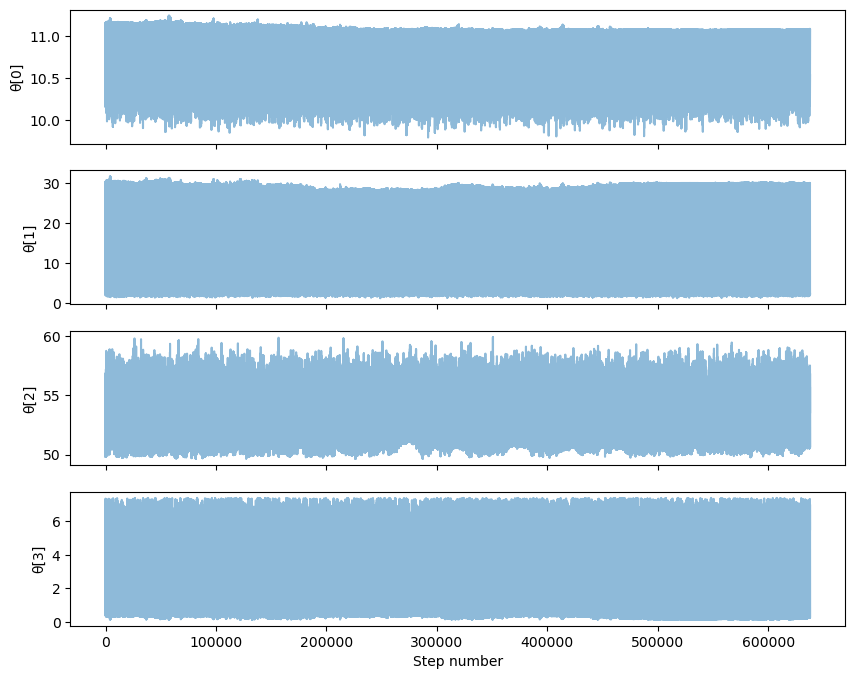

In [33]:
burn_in2 = int(5 * np.max(tau2))  


samples_burned2 = sampler2.get_chain(discard=burn_in2, flat=True)
final_theta2 = samples_burned2[-1]  # Last posterior sample
print("Final theta:", final_theta2)

# Print how many steps were discarded
print(f"Burn-in length: {burn_in2} steps")
print(f"Remaining samples shape: {samples_burned2.shape}")


fig, axes = plt.subplots(ndim, figsize=(10, ndim * 2), sharex=True)

for i in range(ndim):
    axes[i].plot(samples_burned2[:, i], alpha=0.5)
    axes[i].set_ylabel(f"θ[{i}]")

axes[-1].set_xlabel("Step number")
plt.show()

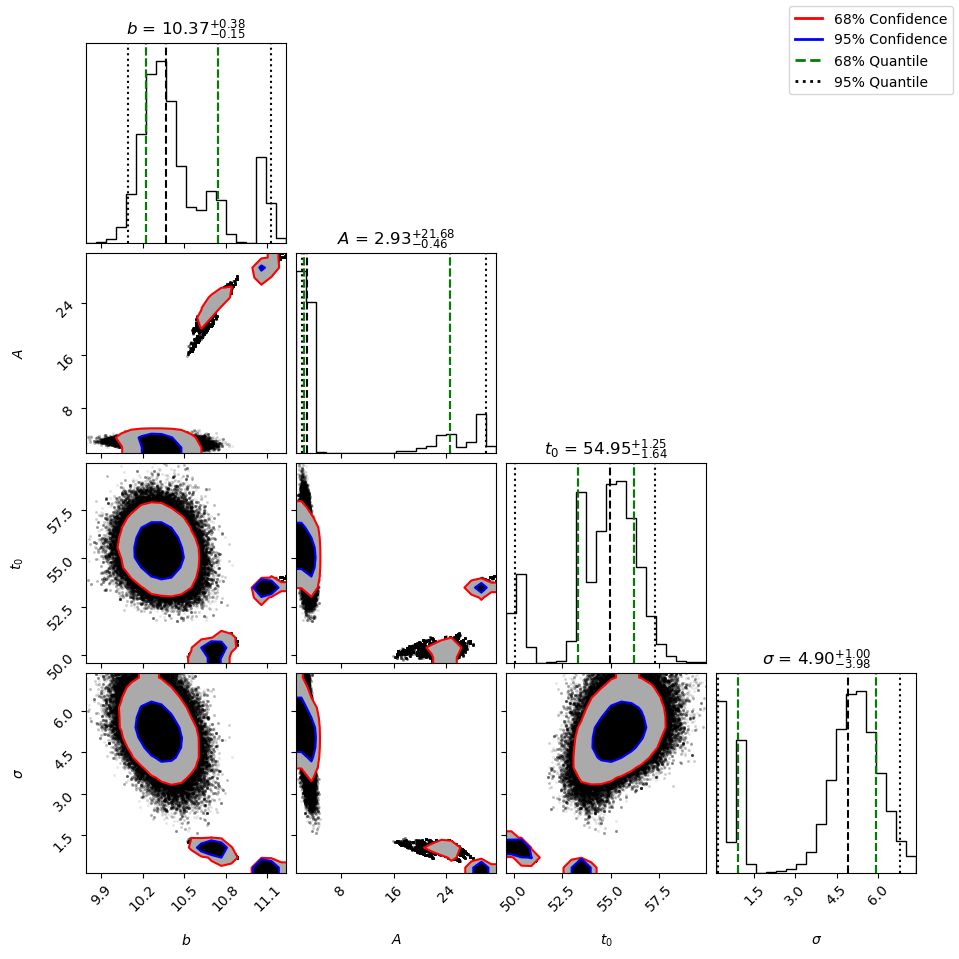

In [34]:
# Define labels
labels = [r"$b$", r"$A$", r"$t_0$", r"$\sigma$"]


percentiles = [16, 50, 84]  # 68% interval
percentiles_95 = [2.5, 50, 97.5]  # 95% interval
theta_median = np.median(samples_burned2, axis=0)
theta_68 = np.percentile(samples_burned2, [16, 84], axis=0)
theta_95 = np.percentile(samples_burned2, [2.5, 97.5], axis=0)

# Create the corner plot
fig = corner.corner(
    samples_burned2,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    plot_datapoints=True,
    plot_contours=True,
    fill_contours=True,
    levels=[0.68, 0.95],  # Confidence intervals
    contour_kwargs={"colors": ["red", "blue"]},  
)

# Get the axes for adding vertical lines
axes = np.array(fig.axes).reshape((4, 4))  # Adjust for 4D case

for i in range(4):  # iterate over the diagonal subplots (marginal distributions)
    ax = axes[i, i]

    # Vertical lines for 68% and 95% intervals
    ax.axvline(theta_68[0, i], color="green", linestyle="--", label="68% Quantile")
    ax.axvline(theta_68[1, i], color="green", linestyle="--")
    
    ax.axvline(theta_95[0, i], color="black", linestyle=":", label="95% Quantile")
    ax.axvline(theta_95[1, i], color="black", linestyle=":")

# Add legend to the plot
handles = [
    plt.Line2D([0], [0], color="red", linewidth=2, label="68% Confidence"),
    plt.Line2D([0], [0], color="blue", linewidth=2, label="95% Confidence"),
    plt.Line2D([0], [0], color="green", linestyle="--", linewidth=2, label="68% Quantile"),
    plt.Line2D([0], [0], color="black", linestyle=":", linewidth=2, label="95% Quantile"),
]

fig.legend(handles=handles, loc="upper right", fontsize=10)

plt.show()

In [35]:
pip install dynesty

Note: you may need to restart the kernel to use updated packages.


In [36]:
import dynesty
import numpy as np

# Prior transform for burst model, maps unit cube [0,1]^ndim to prior ranges
def prior_transform_burst(u):
    
    b = 50 * u[0]  # Uniform prior [0, 50]
    A = 50 * u[1]  # Uniform prior [0, 50]
    t_0 = 100 * u[2]  # Uniform prior [0, 100]
    alpha = np.exp(-5 + 10 * u[3])  # Log-uniform prior, log(alpha) in [-5, 5], log(σW) = −5+(5−(−5))⋅u[3]=−2+4⋅u[3]
    return np.array([b, A, t_0, alpha])

# Nested Sampling for burst model
sampler_burst = dynesty.NestedSampler(logL, prior_transform_burst, ndim=4, logl_args=[data])
sampler_burst.run_nested()
results_burst = sampler_burst.results

# Extract Bayesian evidence (logZ)
logZ_burst = results_burst.logz[-1]
print(f"Log Bayesian Evidence for Burst Model: {logZ_burst:.3f}")



/var/folders/5y/r0thn5qs437_z1rk3srjhx3r0000gn/T/ipykernel_91061/1856353921.py:9: RuntimeWarning: overflow encountered in exp
  theta[0] + theta[1] * np.exp((-theta[3]) * (x - theta[2])))
/var/folders/5y/r0thn5qs437_z1rk3srjhx3r0000gn/T/ipykernel_91061/1856353921.py:9: RuntimeWarning: overflow encountered in multiply
  theta[0] + theta[1] * np.exp((-theta[3]) * (x - theta[2])))
iter: 1782 | bound: 1 | nc: 9 | ncall: 17894 | eff(%):  9.959 | loglstar:   -inf < -258.029 <    inf | logz: -265.978 +/-  0.120 | dlogz: 112.127 >  0.509                                            /var/folders/5y/r0thn5qs437_z1rk3srjhx3r0000gn/T/ipykernel_91061/1856353921.py:9: RuntimeWarning: overflow encountered in exp
  theta[0] + theta[1] * np.exp((-theta[3]) * (x - theta[2])))
iter: 1791 | bound: 1 | nc: 2 | ncall: 17928 | eff(%):  9.990 | loglstar:   -inf < -256.304 <    inf | logz: -264.208 +/-  0.120 | dlogz: 110.328 >  0.509                                            /var/folders/5y/r0thn5qs437_z1rk3sr

Log Bayesian Evidence for Burst Model: -155.251


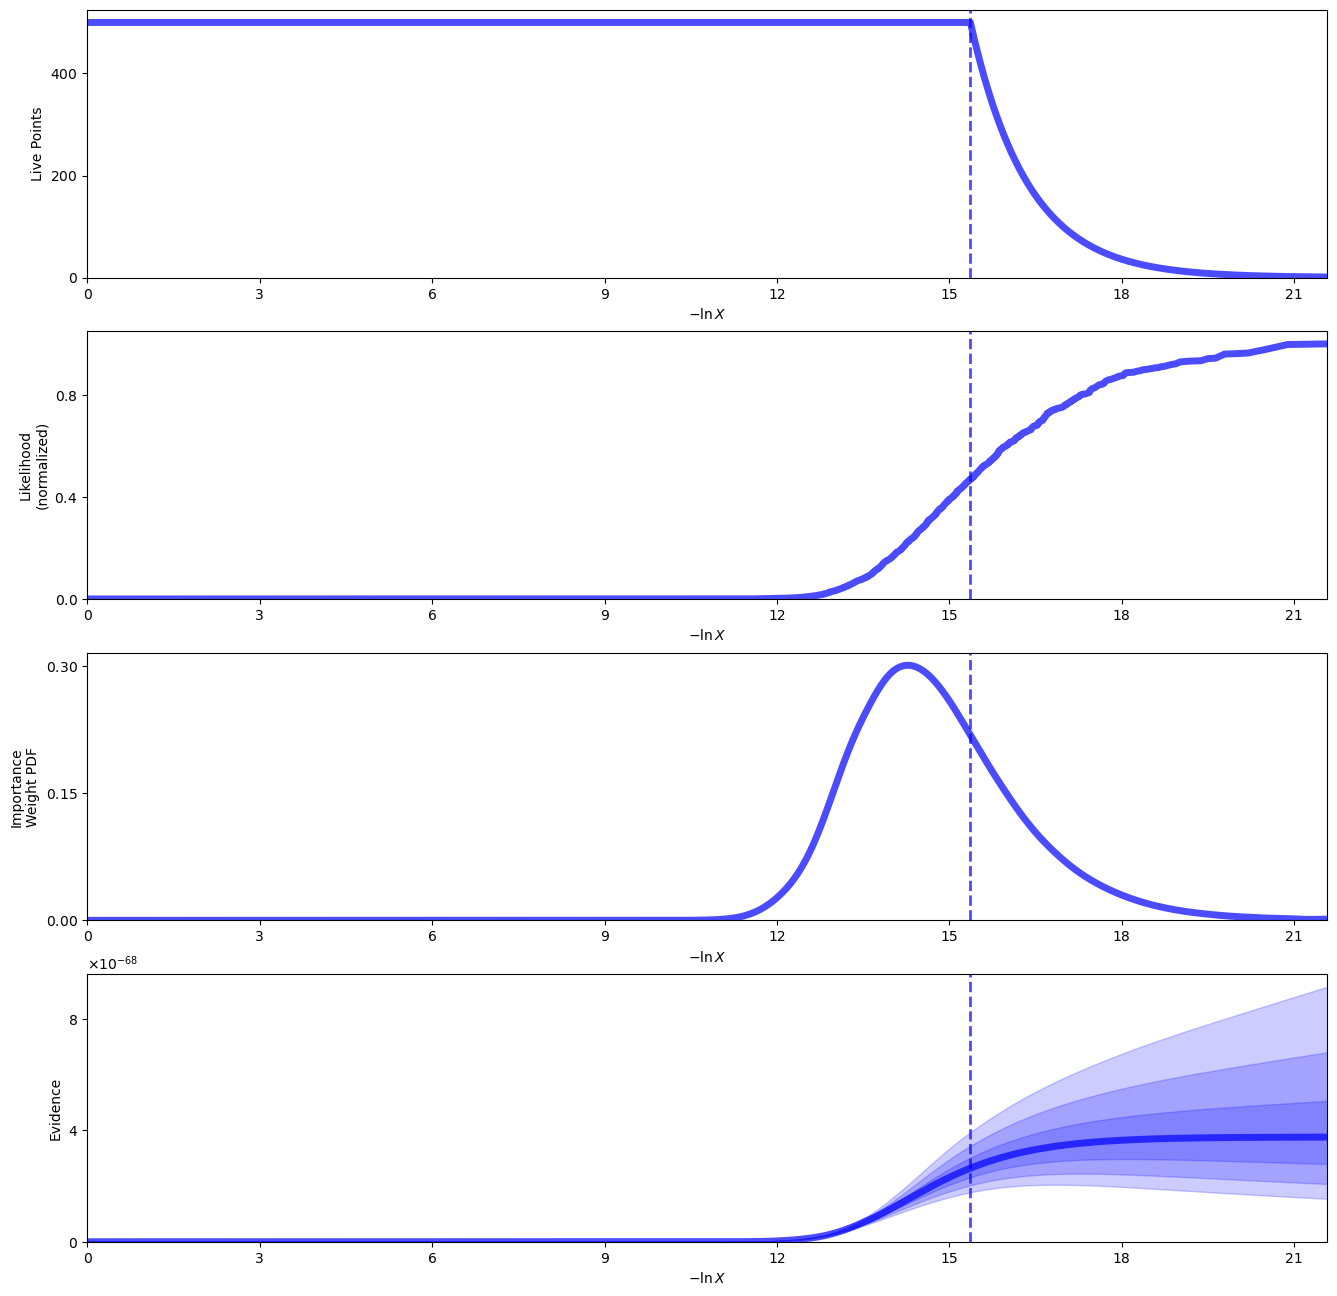

In [37]:
from dynesty import plotting as dyplot

rfig, raxes = dyplot.runplot(results_burst)

In [38]:
# Prior transform for Gaussian model, maps unit cube [0,1]^ndim to prior ranges
def prior_transform_gaussian(u):
    
    b = 50 * u[0]  # Uniform prior [0, 50]
    A = 50 * u[1]  # Uniform prior [0, 50]
    t_0 = 100 * u[2]  # Uniform prior [0, 100]
    sigma_W = np.exp(-2 + 4 * u[3])  # Log-uniform prior, log(sigma_W) in [-2, 2], log(σW) = −2+(2−(−2))⋅u[3]=−2+4⋅u[3]
    return np.array([b, A, t_0, sigma_W])

# Nested Sampling for Gaussian model
sampler_gaussian = dynesty.NestedSampler(logL, prior_transform_gaussian, ndim=4, logl_args=[data])
sampler_gaussian.run_nested()
results_gaussian = sampler_gaussian.results

# Extract Bayesian evidence (logZ)
logZ_gaussian = results_gaussian.logz[-1]
print(f"Log Bayesian Evidence for Gaussian Model: {logZ_gaussian:.3f}")

iter: 850 | bound: 0 | nc: 11 | ncall: 2674 | eff(%): 31.788 | loglstar:   -inf < -1643.281 <    inf | logz: -1651.320 +/-  0.120 | dlogz: 1485.729 >  0.509                                          /var/folders/5y/r0thn5qs437_z1rk3srjhx3r0000gn/T/ipykernel_91061/1856353921.py:9: RuntimeWarning: overflow encountered in exp
  theta[0] + theta[1] * np.exp((-theta[3]) * (x - theta[2])))
iter: 1002 | bound: 0 | nc: 20 | ncall: 3722 | eff(%): 26.921 | loglstar:   -inf < -1043.417 <    inf | logz: -1051.098 +/-  0.120 | dlogz: 884.744 >  0.509                                          /var/folders/5y/r0thn5qs437_z1rk3srjhx3r0000gn/T/ipykernel_91061/1856353921.py:9: RuntimeWarning: overflow encountered in multiply
  theta[0] + theta[1] * np.exp((-theta[3]) * (x - theta[2])))
iter: 2563 | bound: 8 | nc: 10 | ncall: 22674 | eff(%): 11.304 | loglstar:   -inf < -186.373 <    inf | logz: -194.011 +/-  0.115 | dlogz: 36.959 >  0.509                                            /var/folders/5y/r0thn5qs4

Log Bayesian Evidence for Gaussian Model: -155.442


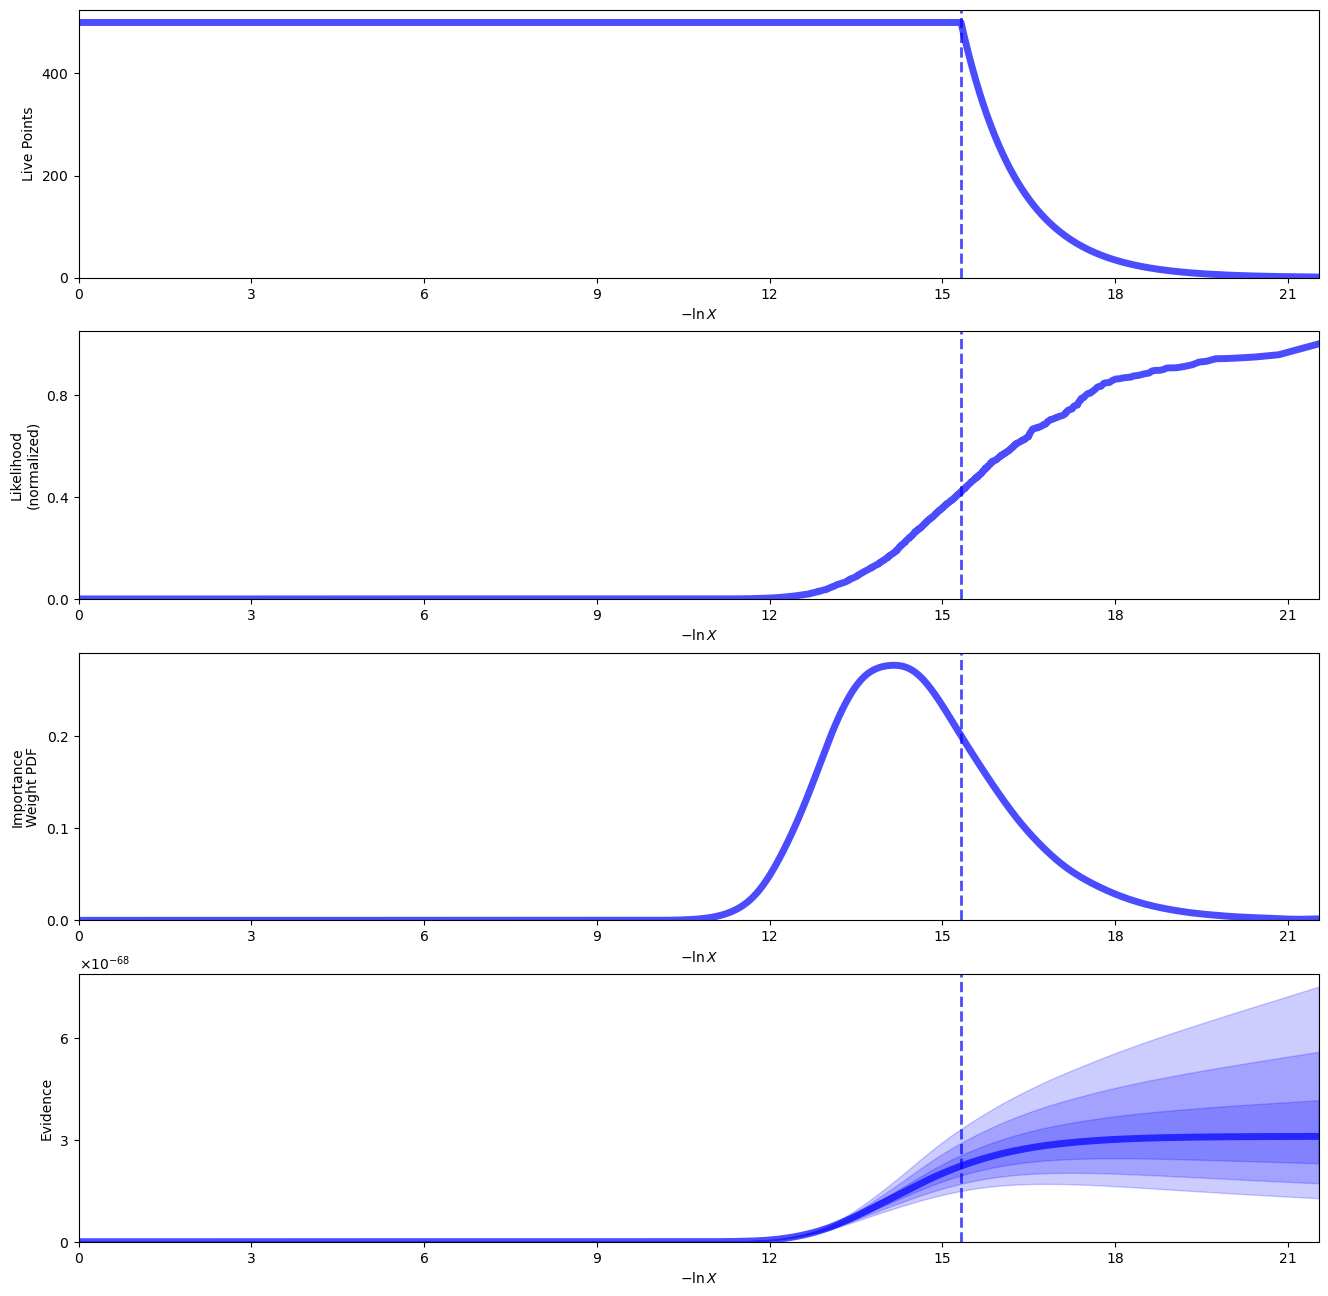

In [39]:
rfig, raxes = dyplot.runplot(results_gaussian)

To be perfectly honest, I still do not quite understand these nested plots and what I can learn from them. I will try to ask you about this at office hours. I mainly just followed the lecture notes and used online resources to use dynesty.

In [40]:
log_BF = logZ_gaussian - logZ_burst
print(f"Log Bayes Factor (Gaussian - Burst): {log_BF:.3f}")

bayes = np.exp(log_BF) # recovering Bayes factor
print(bayes)

Log Bayes Factor (Gaussian - Burst): -0.191
0.8264314158650947


I believe that, since I am computing the Gaussian model evidence relative to the burst one as above in the definition of log_BF, the conclusion is that the Gaussian model is not quite as good for modelling the flux as the burst model.